In [42]:
import requests
from bs4 import BeautifulSoup
import mysql.connector
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

all_products = []
for page in range(1,101):
    #Lấy nội dung HTML của trang web
    url = f'https://www.newegg.com/GPUs-Video-Graphics-Cards/SubCategory/ID-48/Page-{page}'
    response = requests.get(url)
    response = response.content
    soup = BeautifulSoup(response, 'html.parser')
    products = soup.find_all("div", class_="item-cell")
    for product in products:
         # get ItemID
        ItemID = product.find("a", class_="item-title")["href"].split('/')[-1].split('?')[0]
         # get Title
        title = product.find("a", class_="item-title").get_text().strip()
        # get Branding
        brand_element = product.find("a", class_="item-brand")
        if brand_element is not None:
            brand = brand_element["href"].split('/')[-3]
        else:
            brand = "N/A"
        # get rating
        rating_element = product.find("a", class_="item-rating")
        if rating_element is not None:
            rating = rating_element.get("title").split()[2]
        else:
            rating = "N/A"
        # get number of rating
        rating_count_element = product.find("span", class_="item-rating-num")
        if rating_count_element is not None:
            rating_count = rating_count_element.get_text().strip()[1:-1]
        else:
            rating_count = "N/A"
        # get Price
        price_element = product.find("li", class_="price-current").text.strip('$').strip(' ')
        if price_element is not None:
            price_parts = price_element.replace(",", "").replace("$", "").split()
            if len(price_parts) > 0:
                price = price_parts[0].strip()
            else:
                price = 0.0
        else:
            price = 0.0
        # get shipping
        def shipping_to_number(shipping):
            if "Free" in shipping:
                return 0
            elif "N/A" in shipping:
                return None
            else:
                 if shipping == "Special":
                    return 0.0
                 else:
                    return shipping.replace("$", "")
        shipping_element = product.find("li", class_="price-ship")
        if shipping_element is not None:
            shipping = shipping_element.get_text().strip().replace("$", "").replace(" Shipping", "")
            shipping_number = shipping_to_number(shipping)
        else:
            shipping = "N/A"
            shipping_number = 0
        # get image_url
        image_url = product.find("a", class_="item-img")["href"]
        #get total Price
        total_price = float(price) + float(shipping_number)
        #get detail product
        item_features = soup.find('ul', class_='item-features')
        features = soup.find_all('li')

        values = {
            'Max Resolution': '',
            'DisplayPort': '',
            'HDMI': '',
            'DirectX': '',
            'Model': ''
        }
        for feature in features:
            strong_tag = feature.find('strong')
            if strong_tag:
                if strong_tag.text == 'Max Resolution:':
                    values['Max Resolution'] = feature.text.replace('Max Resolution:', '').strip()
                elif strong_tag.text == 'DisplayPort:':
                    values['DisplayPort'] = feature.text.replace('DisplayPort:', '').strip()
                elif strong_tag.text == 'HDMI:':
                    values['HDMI'] = feature.text.replace('HDMI:', '').strip()
                elif strong_tag.text == 'DirectX:':
                    values['DirectX'] = feature.text.replace('DirectX:', '').strip()
                elif strong_tag.text == 'Model #: ':
                    values['Model'] = feature.text.replace('Model #: ', '').strip()
            #print(title)
            # Create a dictionary to store the product information
        product_dict = {
                "ItemID": ItemID,
                "Title": title,
                "Brand": brand,
                "Rating": rating,
                "Rating_Count": rating_count,
                "Price": price,
                "Shipping": shipping,
                "shipping_number": shipping_number,
                "total_price": total_price,
                "image_url": image_url,
                "Max_Resolution": values['Max Resolution'],
                "DisplayPort": values['DisplayPort'],
                "HDMI": values['HDMI'],
                "DirectX": values['DirectX'],
                "Model": values['Model']
            }

        # Append the product dictionary to the list of all products
        all_products.append(product_dict)

    # Print a message after each page is processed to track the progress
df = pd.DataFrame(all_products, columns=['ItemID','Title','Brand', 'Rating', 'Rating_Count','Price','Shipping','shipping_number','total_price',
                                      'image_url','Max_Resolution','DisplayPort','HDMI','Model','DirectX'
                                     ])
df.to_csv('data_products1.csv', index=False)
# After all pages have been processed, print the final list of products
# Print confirmation message
print('Data exported to final_data1.csv')

# Establish a connection to the MySQL server
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="Suong@200994",
  database="test"
)
# Create a cursor object to execute SQL queries
mycursor = mydb.cursor()

# Create a table to store the product information
mycursor.execute("CREATE TABLE IF NOT EXISTS products (ItemID VARCHAR(255), Title VARCHAR(255), Brand VARCHAR(255), Rating VARCHAR(255), Rating_Count VARCHAR(255), Price FLOAT, Shipping VARCHAR(255), shipping_number FLOAT, total_price FLOAT, image_url VARCHAR(255), Max_Resolution VARCHAR(255), DisplayPort VARCHAR(255), HDMI VARCHAR(255), Model VARCHAR(255), DirectX VARCHAR(255))")

# Loop through all the products and insert them into the database
for product in all_products:
    # Convert the details dictionary to a JSON string
    details_json = json.dumps({
        "Max_Resolution": product["Max_Resolution"],
        "DisplayPort": product["DisplayPort"],
        "HDMI": product["HDMI"],
        "DirectX": product["DirectX"],
        "Model": product["Model"]
    })
    # Insert the product information into the database
    sql = "INSERT INTO products (ItemID, Title, Brand, Rating, Rating_Count, Price, Shipping, shipping_number, total_price, image_url, Max_Resolution, DisplayPort, HDMI, Model, DirectX) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (product["ItemID"], product["Title"], product["Brand"], product["Rating"], product["Rating_Count"], product["Price"], product["Shipping"], product["shipping_number"], product["total_price"], product["image_url"], product["Max_Resolution"], product["DisplayPort"], product["HDMI"], product["Model"], product["DirectX"])
    mycursor.execute(sql, val)
    mydb.commit()

# Close the database connection
mydb.close()

df

Data exported to final_data1.csv


,ItemID,Title,Brand,Rating,Rating_Count,Price,Shipping,shipping_number,total_price,image_url,Max_Resolution,DisplayPort,HDMI,Model,DirectX
0,N82E16814932580,GIGABYTE GeForce RTX 4070 Ti GAMING OC 12G Gra...,GIGABYTE,4.9,55,849.99,Free,0,849.99,https://www.newegg.com/gigabyte-geforce-rtx-40...,7680 x 4320,3 x DisplayPort 2.0,1 x HDMI 2.0b,A380 CLI 6G OC,DirectX 12
1,N82E16814932562,GIGABYTE EAGLE OC GeForce RTX 4080 16GB GDDR6X...,GIGABYTE,4,39,1189.99,Free,0,1189.99,https://www.newegg.com/gigabyte-geforce-rtx-40...,7680 x 4320,3 x DisplayPort 2.0,1 x HDMI 2.0b,A380 CLI 6G OC,DirectX 12
2,27N-008H-00001,PELADN AMD Radeon RX 5500XT 8GB GDDR6 PCI Expr...,Peladn,5,1,118.00,Free,0,118.00,https://www.newegg.com/p/27N-008H-00001?Item=9...,7680 x 4320,3 x DisplayPort 2.0,1 x HDMI 2.0b,A380 CLI 6G OC,DirectX 12
3,N82E16814137765,MSI Ventus GeForce RTX 4080 16GB GDDR6X PCI Ex...,MSI,4.5,35,1214.99,Free,0,1214.99,https://www.newegg.com/msi-geforce-rtx-4080-rt...,7680 x 4320,3 x DisplayPort 2.0,1 x HDMI 2.0b,A380 CLI 6G OC,DirectX 12
4,N82E16814883002,Intel Arc A750 Limited Edition 8GB PCI Express...,Intel,4.4,63,249.99,Free,0,249.99,https://www.newegg.com/intel-arc-a750-21p02j00...,7680 x 4320,3 x DisplayPort 2.0,1 x HDMI 2.0b,A380 CLI 6G OC,DirectX 12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593,1FT-000Y-006C9,ASUS TUF Gaming GeForce GTX 1660 SUPER Overclo...,ASUS,N/A,N/A,372.38,Free,0,372.38,https://www.newegg.com/asus-geforce-gtx-1660-s...,7680 x 4320,3 x DisplayPort 1.4,1 x HDMI 2.0b,1660 VENTUS XS 6G OC,
3594,N82E16814202413,SAPPHIRE GPRO 8GB GDDR6 PCI Express 4.0 Video ...,Sapphire-Tech,5,1,459.99,49.99,49.99,509.98,https://www.newegg.com/sapphire-32316-01-21g/p...,7680 x 4320,3 x DisplayPort 1.4,1 x HDMI 2.0b,1660 VENTUS XS 6G OC,
3595,1DW-0027-001J3,ASUS TUF-GTX1660S-O6G-GAMING Asus VCX TUF-GTX1...,ASUS,N/A,N/A,372.38,Free,0,372.38,https://www.newegg.com/asus-model-tuf-gtx1660s...,7680 x 4320,3 x DisplayPort 1.4,1 x HDMI 2.0b,1660 VENTUS XS 6G OC,
3596,N82E16814126632,ASUS Dual GeForce RTX 3060 8GB GDDR6 (PCIe 4.0...,ASUS,N/A,N/A,425.09,Free,0,425.09,https://www.newegg.com/asus-geforce-rtx-3060-d...,7680 x 4320,3 x DisplayPort 1.4,1 x HDMI 2.0b,1660 VENTUS XS 6G OC,


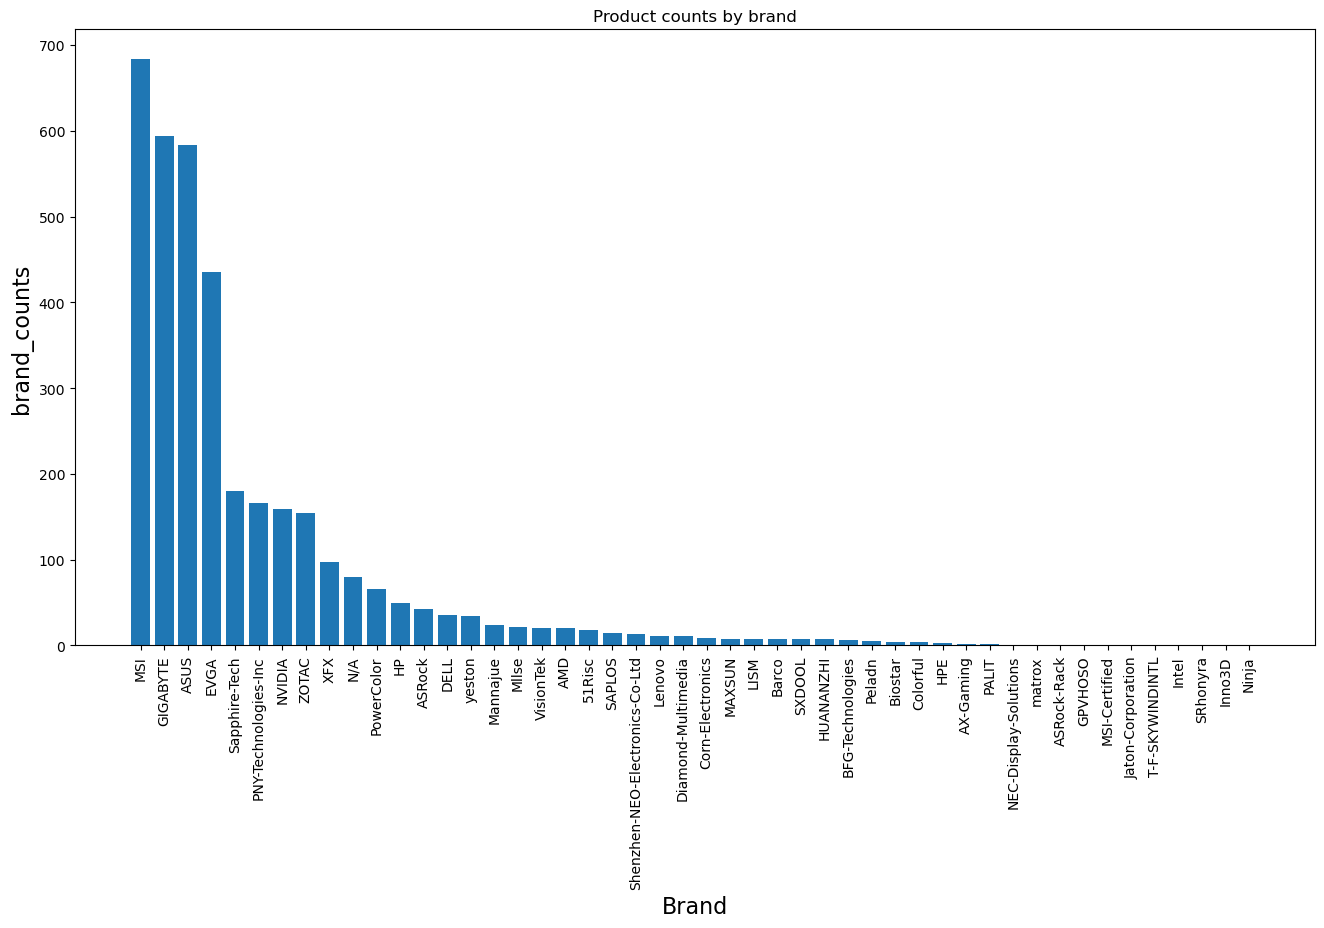

In [43]:
# số lượng sản phẩm của mỗi hãng
df
plt.figure(figsize=(16, 8))
brand_counts = df["Brand"].value_counts()
plt.bar(brand_counts.index, brand_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Brand', fontsize=16)
plt.ylabel('brand_counts', fontsize=16)
plt.title("Product counts by brand")
plt.show()



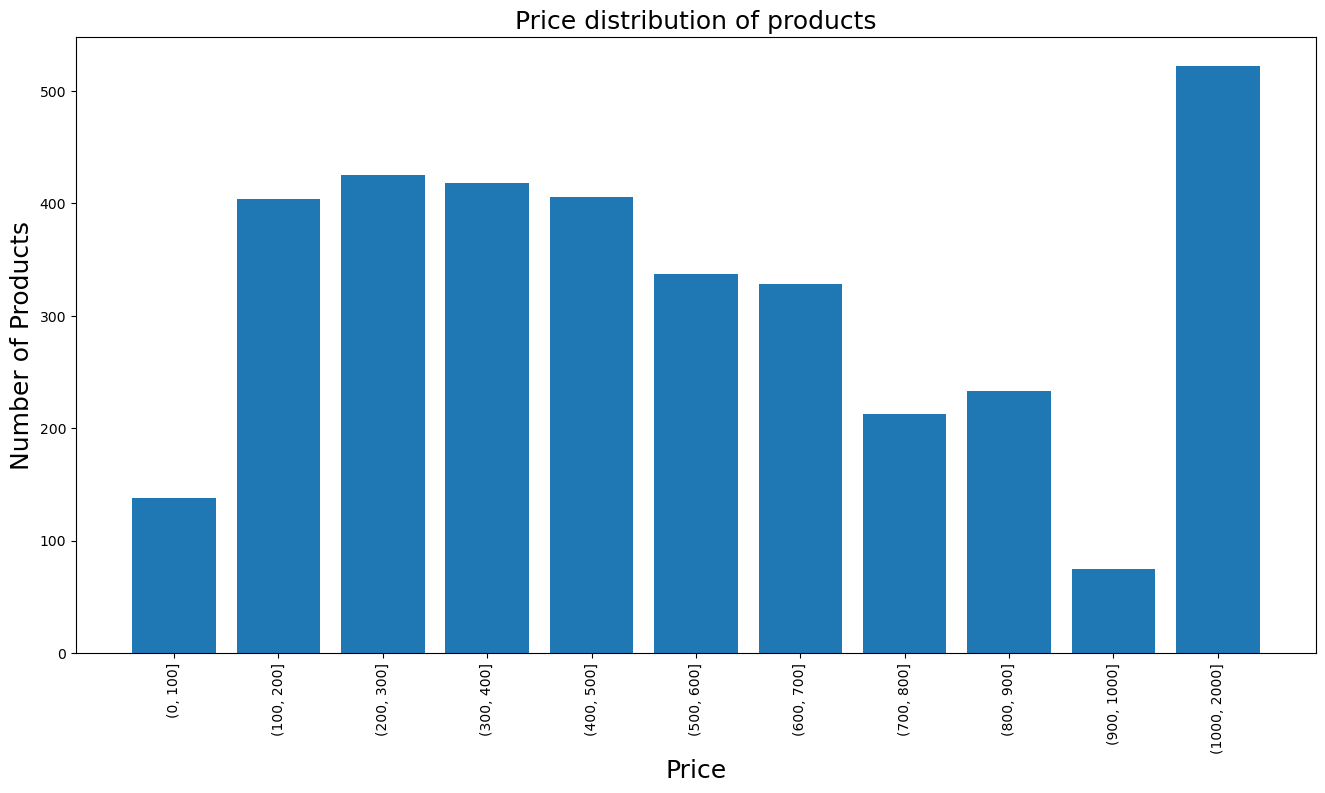

In [44]:
# Phân bố giá của các sảnphẩm
df
plt.figure(figsize=(16, 8))
price_bins = pd.cut(df['Price'].astype(float), bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
price_counts = price_bins.value_counts().sort_index()
plt.bar(price_counts.index.astype(str), price_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Price', fontsize=18)
plt.ylabel('Number of Products', fontsize=18)
plt.title("Price distribution of products", fontsize=18)
plt.show()



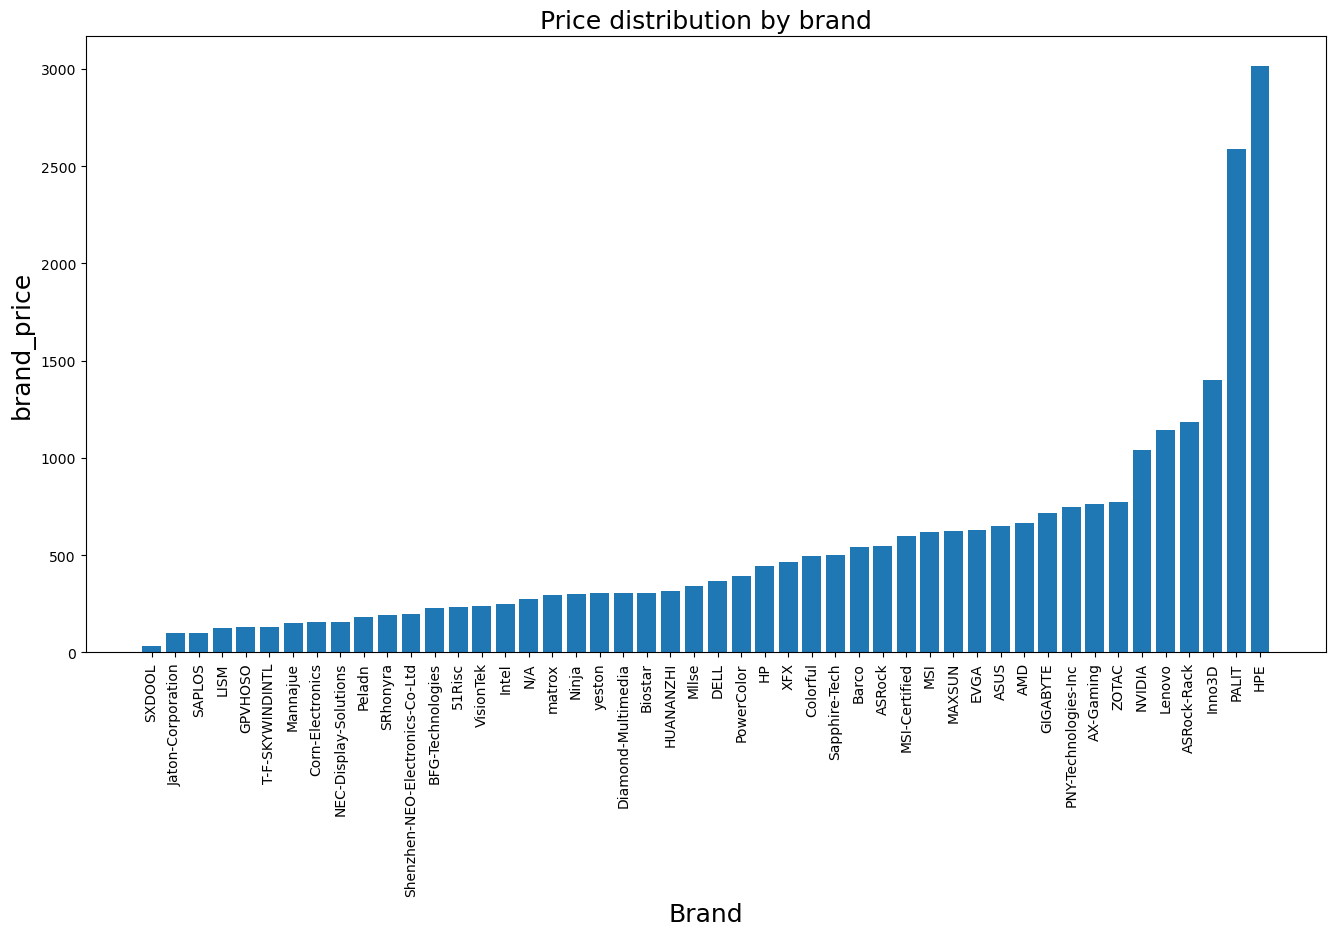

In [45]:

# Phân bố giá sản phẩm theo hãng
df
df['Price'] = df['Price'].astype(float)
plt.figure(figsize=(16, 8))
brand_price = df.groupby("Brand")["Price"].mean().sort_values()
plt.bar(brand_price.index, brand_price.values)
plt.xticks(rotation=90)
plt.xlabel('Brand', fontsize=18)
plt.ylabel('brand_price', fontsize=18)
plt.title("Price distribution by brand", fontsize=18)
plt.show()




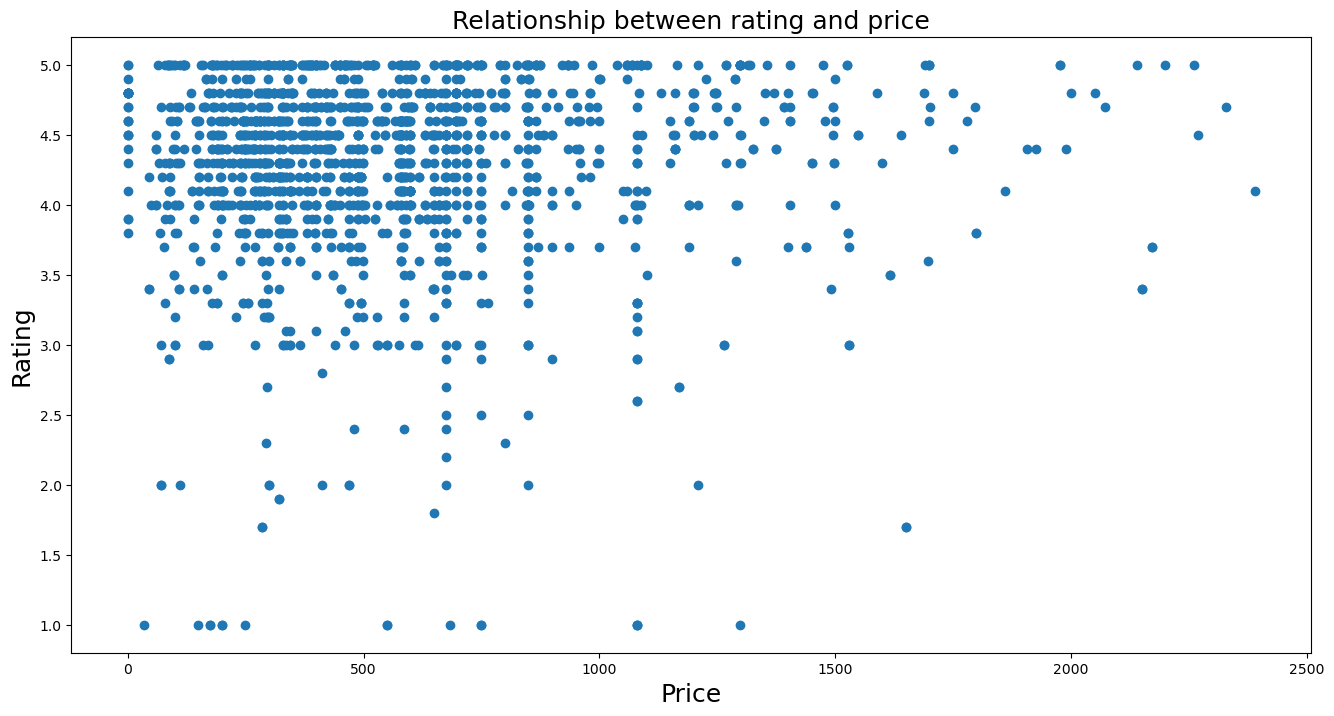

In [52]:
# Biểu diễn mối liên hệ giữa giá sản phẩm và rating của người dùng
df
df = df[df['Rating'] != 0.0]
df = df[df['Rating'] != 'N/A']
plt.figure(figsize=(16, 8))
plt.scatter(df["Price"], df['Rating'].astype(float))
plt.xlabel("Price", fontsize=18)
plt.ylabel("Rating", fontsize=18)
plt.title("Relationship between rating and price", fontsize=18)
plt.show()